In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any, cast
from collections import deque
import random
import cv2
from IPython.display import HTML
from matplotlib.patches import FancyArrow
import pickle

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1: Optimized sigle table for each tuple

In [4]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], device: str) -> None:
        super().__init__()
        self.device = device
        assert grid_shape == (4,4)
        self.n_features = 14
        self.powers = torch.tensor([18**3, 18**2, 18, 1]).view(1,1,1,4).to(self.device)

        self.ttables = nn.Embedding(num_embeddings=18**4, embedding_dim=12)
        
        self.net = nn.Sequential(
            nn.Flatten(), # (n,14,4,12) -> (n,14*4*12)
            nn.Linear(in_features=self.n_features*4*12, out_features=16),
            nn.Linear(in_features=16, out_features=1),
            nn.ReLU()
        ).to(self.device)
        # with torch.no_grad():
        #     for n in range(self.n_features):
        #         self.ttables[n].weight.fill_(0.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Expects tensor of shape (n,14,4,4) """
        x = (x[:, :, :, :] * self.powers).sum(dim=-1) # (n,14,4,4) -> (n,14,4)
        x = self.ttables.forward(x) # (n,14,4) -> (n,14,4,12)
        return self.net(x)
    
    def V_raw(self, x: np.ndarray) -> torch.Tensor:
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,3,4)
        t = torch.from_numpy(x).to(self.device)
        vs = self.forward(t)
        vs = vs.squeeze(dim=-1)
        return vs

    def V(self, x: np.ndarray) -> np.ndarray:
        """ 
        Outputs the value function estimation by the model

        Args:
            x (np.ndarray): n-boards of shape (n,4,4) 

        Returns:
            V (np.ndarray): The value of the n-boards encoded as numpy array with shape (n,)
        
        """
        while len(x.shape) < 3: # (4,4) -> (1,4,4)
            x = x[None, ...]
        x = self.extract_tuples(x) # (n,4,4) -> (n,14,4,3,4)
        t = torch.from_numpy(x).to(self.device)
        with torch.no_grad():
            vs = self.forward(t)
        vs = vs.squeeze(dim=-1)
        return vs.detach().numpy()
    

    def extract_tuples(self, grid: np.ndarray) -> np.ndarray:
        """
        Extract the n-tuples from n boards of shape (n, 4, 4). Returns the tuples as a numpy array of shape \n
        (n, |n_tuple|, 4, 4, 3) = (n, 14, 4, 3, 4) \n
        with the third value representing the rotation (Top, Right, Bottom, Left). The fourth values represents
        the current n-Tuple (index 0), the tuple prediction to the right (index 1) and left (index 2).
        The last values the ith value inside the n-tuple.
        """
        assert len(grid.shape) >= 3 and grid.shape[1] == 4 and grid.shape[2] == 4
        n_tuples = np.zeros(shape=(grid.shape[0],self.n_features,4,4), dtype=grid.dtype)
        for k in range(4):
            g_v = np.rot90(grid, k=k, axes=(1,2))
            n_tuples[:,0,k] = g_v[:,0,::-1] # Outer
            n_tuples[:,1,k] = g_v[:,1,:: 1] # Inner
            n_tuples[:,2,k] = g_v[:, [1,1,0,0], [-2,-1,-1,-2]] # Edge
            n_tuples[:,3,k] = g_v[:, [1,1,0,0], [-3,-2,-2,-3]] # Inner Edge
            n_tuples[:,4,k] = g_v[:, [2,1,1,0], [0,0,1,1]] # Left Z
            n_tuples[:,5,k] = g_v[:, [2,1,1,0], [1,1,2,2]] # Middle Z
            n_tuples[:,6,k] = g_v[:, [2,1,1,0], [2,2,3,3]] # Right Z
            n_tuples[:,7,k] = g_v[:, [2,1,1,0], [1,1,0,0]] # Left Mirror Z
            n_tuples[:,8,k] = g_v[:, [2,1,1,0], [2,2,1,1]] # Middle Mirror Z
            n_tuples[:,9,k] = g_v[:, [2,1,1,0], [3,3,2,2]] # Right Mirror Z
            n_tuples[:,10,k] = g_v[:, [2,1,0,0], [1,1,1,0]] # Left Arrow
            n_tuples[:,11,k] = g_v[:, [2,1,0,0], [2,2,2,1]] # Middle Arrow
            n_tuples[:,12,k] = g_v[:, [2,1,0,0], [3,3,3,2]] # Right Arrow
            n_tuples[:,13,k] = g_v[:, [1,0,0,0], [2,2,1,0]] # Edge Arrow

        return n_tuples
    
# Testing the implementation
net = DQN(grid_shape=env.game.shape, device="cpu")
print(net.extract_tuples(env.game.grid[None, :]).shape)
#print(net.net[0].weight)
net.V(np.array([env.game.grid, env.game.grid, np.rot90(env.game.grid)]))

(1, 14, 4, 4)


array([0.        , 0.        , 0.02495871], dtype=float32)

In [33]:
class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.05, 
                gamma: float = 0.99,
                epsilon: float = 1.0,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, device=self.device)
        
        self._lr = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.gamma = gamma
        self.history: list[Game] = []

        self.batch_size: int = 500
        self.losses: list[float] = []
        self._loss = 0.0
        self._loss_optimizing = 0.0
        self._s = ""
        self._meanV = 0
        self.warm_start_tiles = [1,2,3,4,5,6,7,8,9,10,11,12]
        self.warm_start_p = [20,10,5,5,4,3,1,1,1,1,1,1]
        self.warm_start_n = 3
        self.episode = 0

        self.init()

    def init(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self._lr)
        self.replay_buffer: deque[tuple[State, float]] = deque(maxlen=10_000)

    def remember(self) -> None:
        # for s in self.env.game.history:
        #     if s.parent is not None:
                #s.parent.backtrace_reward(s.reward, lambda_=0.997) # Transform reward to discounted return Gt with half time t=231
        #self.replay_buffer.extend([(s, s.reward + (s.score_bonus - s.parent.score_bonus)*0.5) for s in self.env.game.history[1:]]) 
        self.replay_buffer.extend([(s, s.reward) for s in self.env.game.history[1:]]) 
        self.history.append(env.game)
        self.losses.append(self._loss)

    def reset(self, warm_start: bool = False) -> None:
        self.env.reset()
        if warm_start:
            self.env.game.state.warm_start(tiles=self.warm_start_tiles, p=self.warm_start_p, n=self.warm_start_n)

    def update(self) -> None:
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.choices(self.replay_buffer, k=self.batch_size)
        states, reward = cast(tuple[list[State], list[float]], zip(*batch))

        grids = np.array([s.parent.grid for s in states]) # s_n
        next_grid = np.array([s.grid for s in states]) # s_n+1
        rewards = np.array([r for r in reward]) # (Discounted) reward from s_n to s_n+1
        rewards = torch.from_numpy(rewards).float().to(self.device)

        vn_estimated = self.model.V_raw(grids)
        with torch.no_grad():
            vn_actually = rewards + self.gamma*(self.model.V_raw(next_grid))

        v1 = vn_estimated.detach().numpy()
        v2 = vn_actually.detach().numpy()
        self._s = f"v_n: [{np.min(v1):.3f},{np.max(v1):.3f}], V_target: [{np.min(v2):.3f},{np.max(v2):.3f}], delta [{np.min(v2 - v1):.3f},{np.max(v2 - v1):.3f}]"
        self._meanV = np.mean(v1)

        loss: torch.Tensor = nn.MSELoss()(vn_estimated, vn_actually)
        self._loss = float(loss.detach().numpy())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.no_grad():
            with torch.no_grad():
                vn_estimated = self.model.V_raw(grids)
                vn_actually = rewards + self.gamma*(self.model.V_raw(next_grid))
            self._loss_optimizing = nn.MSELoss()(vn_estimated, vn_actually).detach().numpy()

    def step(self) -> bool:   
        next_state, reward, done, truncated, info = env.step(self.predict(greedy=False))
        return not(done or truncated)
    
    def predict(self, greedy: bool = True) -> Action:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if not greedy and np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        actions = self.get_qv()
        return max(actions, key=actions.get)
    
    def get_qv(self) -> dict[Action, float]:
        qvs = {}
        for a in Action:
            next_states = self.env.game.state.get_next_states(a)
            if len(next_states) == 1:
                continue
            next_states_grid = np.array([s.grid for s in next_states.keys()])
            v = self.model.V(next_states_grid)
            qvs[a] = np.sum([p*v for p, v in zip(next_states.values(), v)])
        return qvs
    
    @property
    def scores(self) -> list[float]:
        return [g.score for g in self.history]
    
    @property
    def highest_tiles(self) -> list[int]:
        return [g.highest_tile for g in self.history]
    
    @property
    def move_counts(self) -> list[int]:
        return [g.move_count for g in self.history] 
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def save(self, path: Path):
        p1 = path.parent / f"{path.name}.agent.dump"
        p2 = path.parent / f"{path.name}.history.dump"
        p3 = path.parent / f"{path.name}.model.dump"
        if p1.exists() or p2.exists() or p3.exists():
            raise FileExistsError("Can't save if the file already exists")
        with open(p1, "wb") as f:
            pickle.dump(self, f)
        with open(p2, "wb") as f:
            pickle.dump(self.history[-200:], f)
        torch.save(self.model.state_dict(), p3)

    @staticmethod
    def load(path: Path) -> Self:
        p1 = path.parent / f"{path.name}.agent.dump"
        if not p1.exists():
            raise FileNotFoundError(f"File {p1.name} does not exist")
        with open(p1, "rb") as f:
            agent: DQNAgent = pickle.load(f)
        agent.load_into(path)
        agent.env = env
        agent.init()
        return agent

    def load_into(self, path:Path) -> None:
        p2 = path.parent / f"{path.name}.history.dump"
        p3 = path.parent / f"{path.name}.model.dump"
        if not p2.exists():
            raise FileNotFoundError(f"File {p2.name} does not exist")
        if not p3.exists():
            raise FileNotFoundError(f"File {p3.name} does not exist")
        with open(p2, "rb") as f:
            self.history = pickle.load(f)
        agent.model.load_state_dict(torch.load(p3))
        agent.model.eval()

    def __getstate__(self) -> object:
        state = self.__dict__.copy()
        dels = ["env", "model", "optimizer", "history", "replay_buffer"]
        for d in dels:
            if d in state:
                del state[d]
        return state
    
    def __setstate__(self, state):
        self.__dict__.update(state)

env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, gamma=0.99, learning_rate=0.005, epsilon=0.2, epsilon_decay=0.001, epsilon_min=0.02)

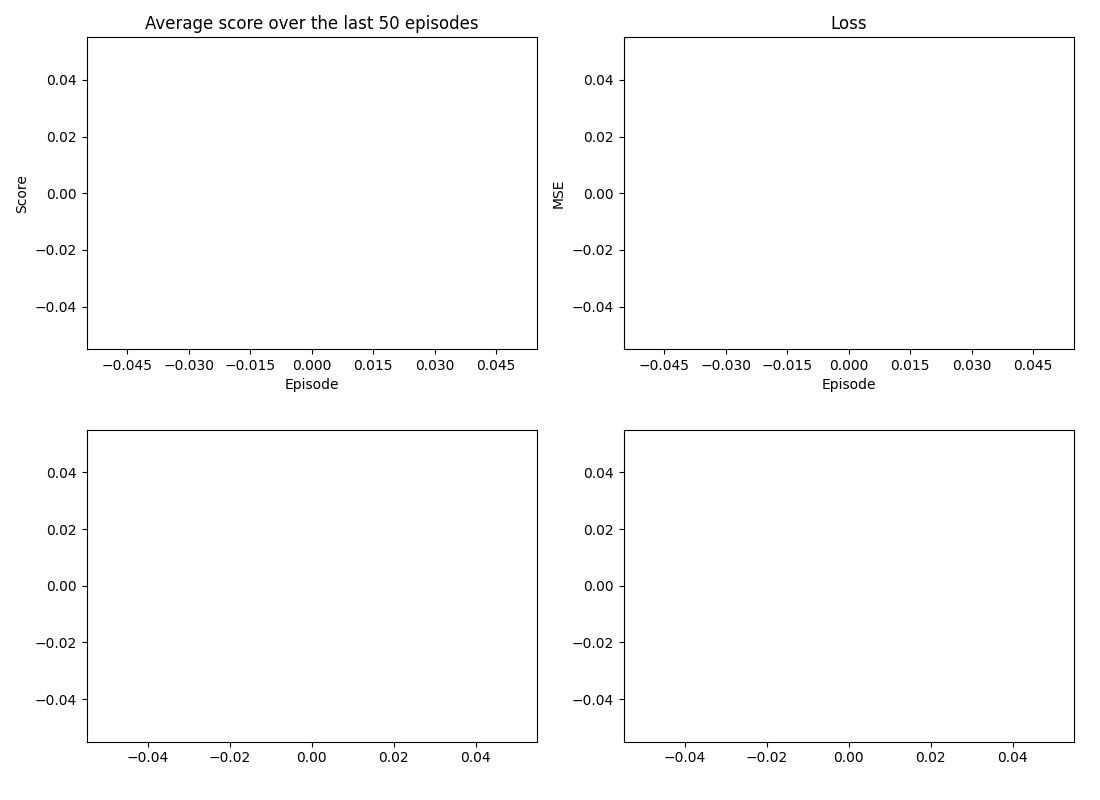

In [31]:
# Live plotting the training progress
%matplotlib widget
plt.ion()  # Interaktiver Modus an
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(11,8))

ax1 = axes[0,0]
ax1.set_xlabel("Episode")
ax1.set_ylabel("Score")
ax1.set_title("Average score over the last 50 episodes")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
p1 = ax1.plot([], label="Scores")

ax2 = axes[0,1]
ax2.set_title("Loss")
ax2.set_xlabel("Episode")
ax2.set_ylabel("MSE")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
p2 = ax2.plot([])


ax3 = axes[1,0]
ax3.set_title("Tile distribution")
ax3.set_xlabel("Episode")
ax3.set_ylabel("%")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.tight_layout()

def update_plot(agent:DQNAgent, tiles: bool = False):
    scores = agent.scores
    if len(agent.losses) > 0 and max(agent.losses) > 0:
        ax2.set_yscale("log")
        p2[0].set_data(range(1,1+len(agent.losses)), agent.losses)
    else:
        ax2.set_yscale("linear")
        p2[0].set_data([], [])
        
    if len(agent.history) == 0:
        p1[0].set_data([], [])
        ax3.clear()
    else:
        if tiles:
            d = []
            for i in range((len(agent.history) - 1)//100  + 1):
                tiles = np.array([g.highest_tile for g in agent.history[100*i:100*(i+1)]])
                stack = np.array([np.count_nonzero(tiles == 2**i) for i in range(3,14)])
                stack = stack / len(tiles)
                d.append(stack)
            d = np.array(d)
            d = d.T
            ax3.clear()
            ax3.stackplot([100*i for i in range(d.shape[1])], d, labels=[f"{2**i}" for i in range(3,14)], colors=cm.Paired.colors)
            ax3.legend()

        p1[0].set_data(range(1,1+len(m := [np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores)+1)])), m)
        
    for ax in axes.flatten():
        ax.relim()
        ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

update_plot(agent, tiles=True)

In [34]:
episode_cap = 30_000
warm_start = False
torch.set_grad_enabled(True)
try:
    for episode in range(agent.episode, episode_cap):
        agent.reset(warm_start=warm_start)
        while env.game.alive:
            done = agent.step()
        agent.remember()
        agent.update()
        agent.decay_epsilon()

        s = f"Episode {episode+1:>4}/{episode_cap}"
        for v in [
            f"Score: {env.game.score:5}", 
            f"Highest tile: {env.game.highest_tile:4}",
            f"Length: {env.game.move_count:3}",
            f"Epsilon: {agent.epsilon:1.3f}",
            f"Average rolling score: {np.mean(agent.scores[max(0,episode-50):]):10.3f}",
            f"Loss: {agent._loss:7.5f}",
            f"Loss improvement {agent._loss - agent._loss_optimizing:7.5f}",
            f"Mean V {agent._meanV:7.1f}",
            f"LR {agent.optimizer.param_groups[0]['lr']}",
        ]:
            s += f" - {v}"
        print(s)

        if episode % 10 == 0:
            update_plot(agent, tiles=(episode%25 == 0))
        agent.episode = episode
    agent.episode += 1

except KeyboardInterrupt:
    pass
update_plot(agent)

Episode    1/30000 - Score:   292 - Highest tile:   16 - Length:  58 - Epsilon: 0.200 - Average rolling score:    292.000 - Loss: 0.00000 - Loss improvement 0.00000 - Mean V     0.0 - LR 0.005
Episode    2/30000 - Score:   944 - Highest tile:   64 - Length: 112 - Epsilon: 0.200 - Average rolling score:    618.000 - Loss: 0.00000 - Loss improvement 0.00000 - Mean V     0.0 - LR 0.005
Episode    3/30000 - Score:  1520 - Highest tile:  128 - Length: 163 - Epsilon: 0.199 - Average rolling score:    918.667 - Loss: 0.00000 - Loss improvement 0.00000 - Mean V     0.0 - LR 0.005
Episode    4/30000 - Score:   544 - Highest tile:   64 - Length:  78 - Epsilon: 0.199 - Average rolling score:    825.000 - Loss: 0.00000 - Loss improvement 0.00000 - Mean V     0.0 - LR 0.005
Episode    5/30000 - Score:  1272 - Highest tile:  128 - Length: 135 - Epsilon: 0.199 - Average rolling score:    914.400 - Loss: 242.93681 - Loss improvement 4.28461 - Mean V     0.2 - LR 0.005
Episode    6/30000 - Score:  1320

In [35]:
agent.reset()

while agent.env.game.alive:
    a = agent.predict(greedy=True)
    agent.env.step(a)

html = agent.env.game.render_game(state_func=lambda s: f"agents expectes reward {agent.model.V(s.grid)[0]:1.0f} and final score {s.score + agent.model.V(s.grid)[0]:1.0f}").to_jshtml()
plt.close()
HTML(html)

In [29]:
agent.model.V(np.array([[1,1,1,0], [0,0,0,0], [0,0,0,0], [0,0,0,0]]))

array([88.311775], dtype=float32)

In [ ]:
HTML(agent.history[6728].render_game(state_func=lambda s: f"agents expectes reward {agent.model.V(s.grid)[0]:1.0f} and final score {s.score + agent.model.V(s.grid)[0]:1.0f}").to_jshtml())

In [ ]:
agent.save(Path("../models/2025_07_23 1024 agent 1"))